# Skin lesion

## 前準備
### 主要パッケージを読み込む
loggerの設定も行う

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/skin_lesion')
CLASS_LABELS = ('akiec','bcc','bkl','df','mel','nv','vasc')
IMAGE_EXT = '.jpg'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
import tut_utils
df_dataset = tut_utils.create_dataset_df(DATA_ROOT, CLASS_LABELS, IMAGE_EXT)
assert set(CLASS_LABELS) == set(df_dataset['class_label'].unique(
)), 'Discrepancy between CLASS_LABELS and df_dataset'
display(df_dataset)

filepath class_label  class
0    Data\Images\skin_lesion\akiec\ISIC_0024329.jpg       akiec      0
1    Data\Images\skin_lesion\akiec\ISIC_0024450.jpg       akiec      0
2    Data\Images\skin_lesion\akiec\ISIC_0024511.jpg       akiec      0
3    Data\Images\skin_lesion\akiec\ISIC_0024522.jpg       akiec      0
4    Data\Images\skin_lesion\akiec\ISIC_0024913.jpg       akiec      0
..                                              ...         ...    ...
247   Data\Images\skin_lesion\vasc\ISIC_0032076.jpg        vasc      6
248   Data\Images\skin_lesion\vasc\ISIC_0032745.jpg        vasc      6
249   Data\Images\skin_lesion\vasc\ISIC_0032839.jpg        vasc      6
250   Data\Images\skin_lesion\vasc\ISIC_0033135.jpg        vasc      6
251   Data\Images\skin_lesion\vasc\ISIC_0033158.jpg        vasc      6

[252 rows x 3 columns]

### クラスごとの画像数を確認する

In [4]:
df_dataset['class_label'].value_counts()

vasc     36
mel      36
nv       36
bcc      36
df       36
akiec    36
bkl      36
Name: class_label, dtype: int64

### 各クラスの画像を表示してみる

akiec


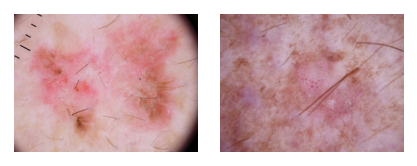

bcc


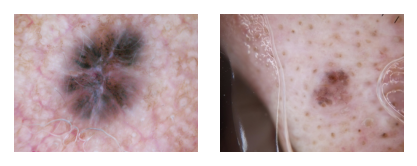

bkl


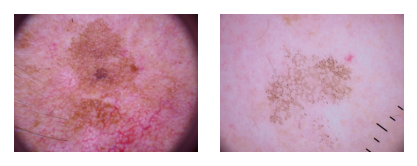

df


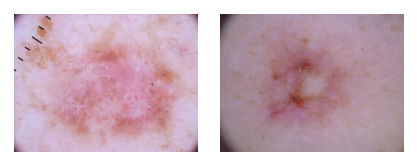

mel


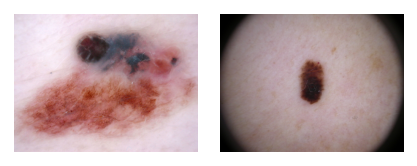

nv


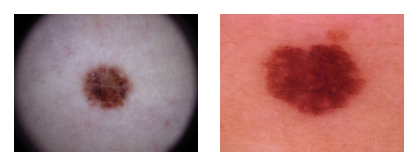

vasc


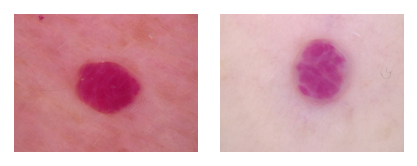

In [5]:
tut_utils.show_images_each_class(df_dataset, n_rows=1, n_cols=2, figsize=(3, 2))

### データ読み込み用の関数を作成

In [6]:
import tensorflow as tf
IMG_SHAPE = (224, 224, 3)


def load_img(filepath):
    return np.atleast_3d(
        tf.keras.preprocessing.image.load_img(
            filepath,
            color_mode='grayscale' if IMG_SHAPE[2] == 1 else 'rgb',
            target_size=IMG_SHAPE))


def load_dataset(df_train, df_test):
    train_data = np.stack(
        [load_img(filepath) for filepath in df_train['filepath']])
    train_labels = df_train['class']
    test_data = np.stack(
        [load_img(filepath) for filepath in df_test['filepath']])
    test_labels = df_test['class']

    train_data = train_data / 255
    test_data = test_data / 255

    return train_data, train_labels, test_data, test_labels

## Data augmentation
いくつかの画像に対して実際にaugmentationを適用し表示する

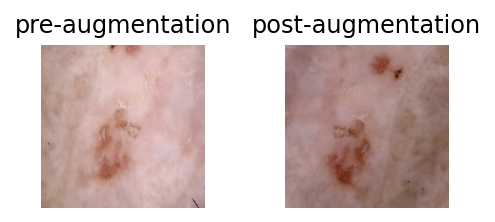

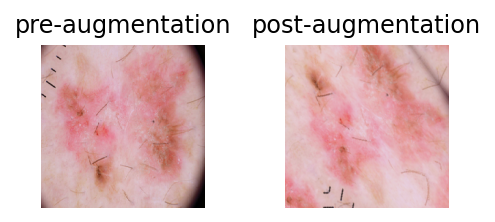

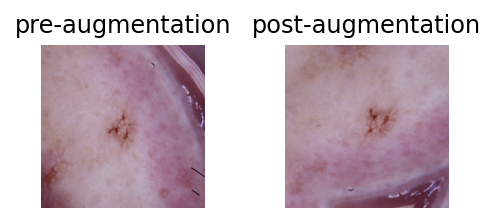

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def create_generator():
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=.1,
        shear_range=15,
        channel_shift_range=.25,
        fill_mode='reflect',
    )
    return datagen


N_TEST = 3


def test_generator(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    df_tmp = df_dataset.iloc[N_TEST:(N_TEST + 1)]
    train_data, train_labels, test_data, test_labels = load_dataset(
        df_train, df_tmp)
    datagen = create_generator()
    flow = datagen.flow(train_data, train_labels, batch_size=1, shuffle=False)
    for i in range(N_TEST):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(train_data[i].squeeze())
        plt.title('pre-augmentation')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        t = flow[i]
        plt.imshow(t[0].squeeze())
        plt.title('post-augmentation')
        plt.axis('off')
        plt.show()


test_generator(df_dataset)

## モデル作成
[ImageNet](http://www.image-net.org/)で事前学習されたMobileNetV2を基にモデルを作成する。
[参考](https://www.tensorflow.org/tutorials/images/transfer_learning)
<div class="alert alert-block alert-warning">
<b>注意:</b> BatchNormalizationレイヤーのmomentumは手動で再設定する</div>

In [8]:
import tensorflow as tf
import tensorflow.python
import tensorflow.python.keras
from tensorflow import keras
from tensorflow.keras import layers
BN_MOMENTUM = 0.90


def is_batch_normalization(layer):
    '''
    Check if the layer is a batch normalization layer.
    Note: Not the most robust way of checking.
    '''
    return layer.__class__.__name__ == 'BatchNormalization'


def set_momentum(model, momentum):
    for layer in model.layers:
        if is_batch_normalization(layer):
            layer.momentum = momentum


def build_model_pretrained():
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    set_momentum(base_model, BN_MOMENTUM)
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASS_LABELS))
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model


model = build_model_pretrained()

## K-Fold 交差検証
`loss`の値を早期終了の基準として使用する。
<div class="alert alert-block alert-warning">
<b>注意:</b> 今回、trainingデータを用いて学習を終了させていますが、本来はvalidationデータ(trainingでもtestでもないデータ)を用いた方がよいです。
</div>

2020-06-16 10:44:19,960 INFO :1th iteration of 3-fold CV
1/128 epoch:   0%|          | 0/168 [00:00<?, ?batch/s]2020-06-16 10:44:23,717 WARNING :sample_weight modes were coerced from
  ...
    to  
  ['...']
84/128 epoch [2.6m/4m (1.9s/epoch) last_epoch=(loss=0.00858,accuracy=1)]: 100%|██████████| 168/168 [00:01<00:00, 85.02batch/s, loss=0.00361, accuracy=1]


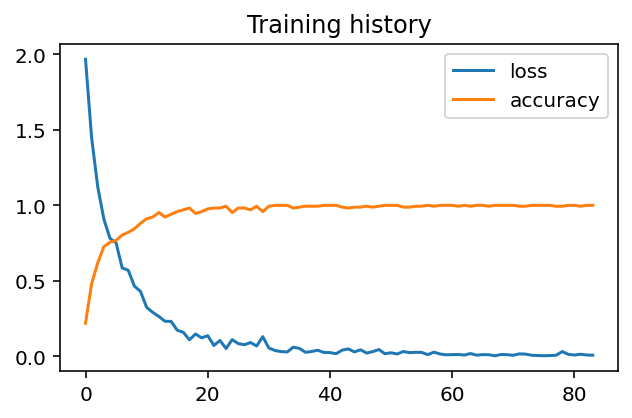

2020-06-16 10:47:02,347 INFO :2th iteration of 3-fold CV
1/128 epoch:   0%|          | 0/168 [00:00<?, ?batch/s]2020-06-16 10:47:05,403 WARNING :sample_weight modes were coerced from
  ...
    to  
  ['...']
70/128 epoch [2.2m/4m (1.9s/epoch) last_epoch=(loss=0.0155,accuracy=0.997)]: 100%|██████████| 168/168 [00:01<00:00, 93.43batch/s, loss=0.000936, accuracy=0.994]


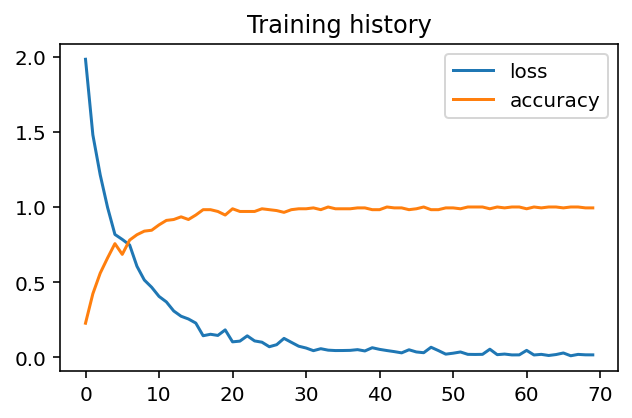

2020-06-16 10:49:18,678 INFO :3th iteration of 3-fold CV
1/128 epoch:   0%|          | 0/168 [00:00<?, ?batch/s]2020-06-16 10:49:21,401 WARNING :sample_weight modes were coerced from
  ...
    to  
  ['...']
86/128 epoch [2.7m/4m (1.9s/epoch) last_epoch=(loss=0.016,accuracy=0.998)]: 100%|██████████| 168/168 [00:01<00:00, 84.42batch/s, loss=0.0119, accuracy=0.994]


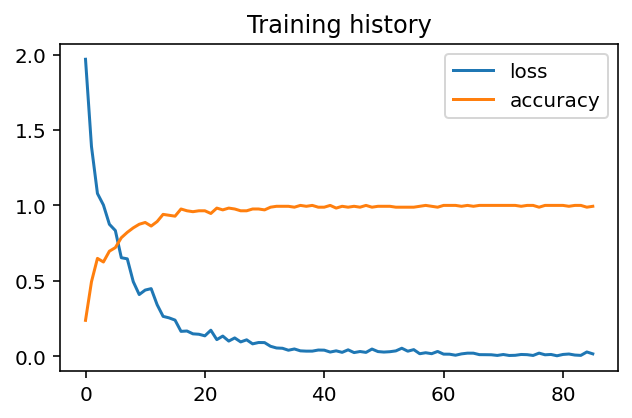

In [9]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 3
kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

BATCH_SIZE = 8
EPOCHS = 128
PATIENCE = 16


def predict_multiclass(model, data, index):
    logits = model.predict(data)
    predictions = tf.nn.softmax(logits).numpy()
    df_result = pd.DataFrame(
        {
            'pred_logits': list(logits),
            'pred_proba': list(predictions),
            'pred_class': np.argmax(predictions, axis=1)
        },
        index=index)
    return df_result


results = []
for i_iter, (train_index, test_index) in enumerate(
        kfold.split(df_dataset['filepath'], df_dataset['class'])):
    logger.info('{i}th iteration of {k}-fold CV'.format(i=i_iter + 1,
                                                        k=K_FOLD))
    df_train = df_dataset.iloc[train_index]
    df_test = df_dataset.iloc[test_index]
    train_data, train_labels, test_data, test_labels = load_dataset(
        df_train, df_test)
    model = build_model_pretrained()
    datagen = create_generator()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        restore_best_weights=True,
        patience=PATIENCE,
        min_delta=0.01)
    with tut_utils.ProgressBarCallback(EPOCHS, len(train_index) // BATCH_SIZE,
                                       BATCH_SIZE) as pbar:
        result = model.fit(datagen.flow(train_data,
                                        train_labels.values,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE),
                           epochs=EPOCHS,
                           verbose=0,
                           callbacks=[early_stopping, pbar])
    pd.DataFrame(result.history).plot(title='Training history', figsize=(5, 3))
    plt.show()
    results.append(predict_multiclass(model, test_data, test_index))

In [10]:
df_result = pd.concat(results, axis=0)
df_result = df_dataset.join(df_result)
display(df_result)

filepath class_label  class  \
0    Data\Images\skin_lesion\akiec\ISIC_0024329.jpg       akiec      0   
1    Data\Images\skin_lesion\akiec\ISIC_0024450.jpg       akiec      0   
2    Data\Images\skin_lesion\akiec\ISIC_0024511.jpg       akiec      0   
3    Data\Images\skin_lesion\akiec\ISIC_0024522.jpg       akiec      0   
4    Data\Images\skin_lesion\akiec\ISIC_0024913.jpg       akiec      0   
..                                              ...         ...    ...   
247   Data\Images\skin_lesion\vasc\ISIC_0032076.jpg        vasc      6   
248   Data\Images\skin_lesion\vasc\ISIC_0032745.jpg        vasc      6   
249   Data\Images\skin_lesion\vasc\ISIC_0032839.jpg        vasc      6   
250   Data\Images\skin_lesion\vasc\ISIC_0033135.jpg        vasc      6   
251   Data\Images\skin_lesion\vasc\ISIC_0033158.jpg        vasc      6   

                                           pred_logits  \
0    [4.122185, 2.1404026, 4.943124, -4.0474534, -4...   
1    [-5.8558416, 3.6930163, 3.0433295, 7.7216806, ...   
2    [3.5194962, 4.26519, -3.1880996, -0.10651551, ...   
3    [-2.7048438, 0.8109643, 0.37319323, 7.3335657,...   
4    [-1.3159856, 3.3569732, 1.513352, 7.4438977, -...   
..                                                 ...   
247  [-5.8881335, -2.3353298, -3.383476, 3.6795166,...   
248  [-4.8541117, -2.710268, 0.09252355, 0.9338002,...   
249  [-0.53682816, -3.227065, -3.786303, -6.3163066...   
250  [-6.991668, 2.135635, -3.3289497, -4.2509828, ...   
251  [-4.0864873, -5.1038847, -5.4151373, -1.515222...   

                                            pred_proba  pred_class  
0    [0.29301888, 0.040384836, 0.66592413, 8.295956...           2  
1    [1.2310142e-06, 0.01726948, 0.009018283, 0.970...           3  
2    [0.3136518, 0.66114783, 0.0003831562, 0.008350...           1  
3    [4.253649e-05, 0.0014310589, 0.0009237108, 0.9...           3  
4    [0.00015355216, 0.016432209, 0.0026002878, 0.9...           3  
..                                                 ...         ...  
247  [1.325732e-07, 4.628268e-06, 1.6226109e-06, 0....           6  
248  [1.690623e-05, 0.00014424667, 0.0023787178, 0....           6  
249  [8.67798e-05, 5.889298e-06, 3.366583e-06, 2.68...           6  
250  [4.2782503e-08, 0.00039373475, 1.667112e-06, 6...           6  
251  [0.00010639055, 3.8463888e-05, 2.8175906e-05, ...           6  

[252 rows x 6 columns]

## 評価
### 混同行列

In [11]:
df_cm = tut_utils.confusion_matrix(df_result)
print('Accuracy = {n} / {d} = {a:.03g}%'.format(n=df_cm.values.trace(),
                                                d=df_cm.values.sum(),
                                                a=100 * df_cm.values.trace() / df_cm.values.sum()))

display(df_cm)

Accuracy = 140 / 252 = 55.6%


Prediction  akiec  bcc  bkl  df  mel  nv  vasc
Truth                                         
akiec          11    5    9   8    1   2     0
bcc             2   18    8   6    1   0     1
bkl             1    1   23   4    5   2     0
df              1    0    6  20    3   6     0
mel             1    0    9   5   13   6     2
nv              0    1    2   3    4  26     0
vasc            0    1    1   3    1   1    29

### ROCカーブ

(7, 252)


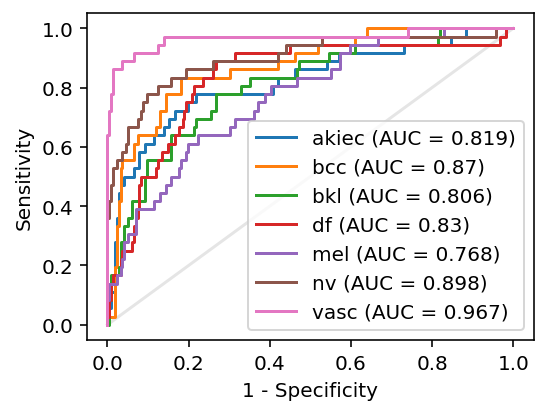

In [12]:
tut_utils.plot_roc_curves(df_result, figsize=(4, 3))
plt.show()